This blog post outlines an implementation of linear classification via logistic regression with gradient descent, stochastic gradient descent, and stochastic gradient descent with momentum. I will address the implementations and differing convergence rates of each method.

Logistic Regression is based around the sigmoid function, a convex function defined as: $$\sigma(x) = \frac{1}{1 + e^{-x}}$$.

Using numpy, we define a vectorized sigmoid function as:
```python

    def __sigmoid(self, z) -> np.ndarray:
        ''' Internal method to calculate sigmoid
        @param z: array of shape (n_samples,)
        @return: array of shape (n_samples,)
        '''

        return 1 / (1 + np.exp(-z))

```




# Gradient Descent

This leads to the logistic loss function given in code as:
```python 
    def __loss(self, X, y) -> float:
        ''' Internal method to calculate logistic loss
        @param y: array of shape (n_samples,)
        @param y_pred: array of shape (n_samples,)
        @return: float
        '''
        y_pred = self.__predict(X)

        if self.__np_array_is_empty_or_null(y) or self.__np_array_is_empty_or_null(y_pred): raise Exception('y and y_pred must not be empty')
        if len(y) != len(y_pred): raise Exception('y and y_pred must have same length')

        return (-y*np.log(self.__sigmoid(y_pred)) - (1-y)*np.log(1-self.__sigmoid(y_pred))).mean()

```


As we can see, this vectorized loss function is a convex function between the model's predictions and the true labels. This is important because it allows us to use gradient descent to find a global minimum for our model's overall cost (given by the mean of the individual loss calculations). The gradient of the loss function is given by:

```python
    def __grad(self, X, y, y_pred) -> np.ndarray:
        ''' Internal method to calculate gradient of empirical risk of logistic loss
        @param X: array of shape (n_samples, n_features + 1)
        @param y: array of shape (n_samples,)
        @param y_pred: array of shape (n_samples,)
        @return: array of shape (n_features + 1,)
        '''

        return (1 / len(y)) * ((self.__sigmoid(y_pred) - y) @ X)

```


These calculations perform the legwork of our gradient descent algorithm. We can now define the (simplest) gradient descent algorithm itself as:
$$ w_{i+1} = w_{i} - \nabla L(w) $$


## Learning Rate

Now naturally, we'd like our algorithm to converge to a global minimum. And as it stands, this is not guaranteed. We can however, make it more likely by using a learning rate $\alpha \in (0,1)$ to control the step size of our gradient descent algorithm. The intuition behind this is that if we take a step in the direction of the gradient, we will move closer to the global minimum. But if we step too far, we may overshoot the global minimum and end up somewhere worse. 


![When alpha is too large we can bounce around the global minimum and never reach it.       [stats.stackexchange.com](https://stats.stackexchange.com/q/562637/)](./images/gradient-alpha-overshoot.png)




By making smaller steps, we decrease the likelihood of overshooting the global minimum. By sufficiently decreasing our step size, we can guarantee convergence at the cost of training time. Our new gradient descent algorithm is given as:

$$ w_{i+1} = w_{i} - \alpha \nabla L(w) $$

## Stochastic Gradient Descent

This equation can be quite costly to compute, especially if we have a large number of samples. We can reduce the cost of this computation by using a batch $b$ to compute the gradient of the loss function over a subset of the data. The intuition behind this is that the gradient of the loss function over a subset of the data is probably a good approximation of the gradient of the loss function over the entire dataset. And taking a step in the direction of this approximation should bring us closer to the global minimum.

This is known as stochastic gradient descent. The new algorithm is given as:

$$ w_{i+1} = w_{i} - \alpha \nabla L(w)_b $$

where $b$ is a random subset of the data. Then we can iterate over the entire dataset by repeating this process for each batch.


## Stochastic Gradient Descent with Momentum

The problem with stochastic gradient descent is that it can be noisy. This is because we are taking a step in the direction of the gradient of the loss function over a random subset of the data. This can lead to the algorithm taking certain steps that are orthogonal or even opposite to the direction of the global minimum, and thus increase the noise at each step and increasing training time. We can reduce this noise by using momentum. The idea behind momentum is that we can keep track of the direction of the previous step and use this to help us take a step in the right direction. We can do this by adding a momentum term to our gradient descent algorithm, where $\beta \in (0,1)$ is the momentum coefficient. This gives us the following equation:

$$ w_{i+1} = w_{i} - (\alpha \nabla L(w)_b + \beta (w_{i} - w_{i-1})) $$






## Gradient Descent Implementations

For ease of implementation, gradient descent and its stochastic variants are implemented in two functions `LogisticRegression.fit` and `LogisticRegression.fit_stochastic`.

`LogisticRegression.fit_stochastic` handles both stochastic gradient descent and stochastic gradient descent with momentum. As only difference between the two is the addition of the momentum term.


We define our model fit via gradient descent as:
```python
def __fit(self, X, y, alpha, epochs) -> None:
        ''' Internal method to fit the model
        @param X: array of shape (n_samples, n_features + 1)
        @param y: array of shape (n_samples,)
        @param alpha: learning rate
        @param epochs: number of epochs
        @return: None
        '''
        if self.w is not None: raise Exception('Model is already trained')

        _, n_features = X.shape
        self.w = self.__get_random_weights(n_features)
        self.__record_history(self.__loss(X, y), self.__score(X, y))

        for epoch in range(epochs):
        
            y_pred = self.__predict(X)

            # Update weights       
            grad = self.__grad(X, y, y_pred)
            update_amt  = (alpha * grad)
            self.w -= update_amt

            # Record loss and check for convergence
            loss = self.__loss(X, y)
            score = self.__score(X, y)

            self.__record_history(loss, score)
            if (np.linalg.norm(update_amt) <= self.epsilon): break
        print(f"Fit model with gradient descent in {epoch+1}/{epochs}(max) epochs.")
```

The code for this follows from the above equation. We initialize our weights to random values, and then update them using the gradient of the loss function. We then record the loss and score of the model and check for convergence. If the model has converged, we break out of the loop. Otherwise, we continue to the next epoch.

We do this until convergence or until we reach the maximum number of epochs.


Similarly, we define our model fit via stochastic gradient descent as:
```python

 def __fit_stochastic(self, X, y, alpha, epochs, batch_size, momentum=False, beta=0.8) -> None:
        ''' Internal method to fit the model using stochastic gradient descent
        @param X: array of shape (n_samples, n_features + 1)
        @param y: array of shape (n_samples,)
        @param alpha: learning rate
        @param epochs: number of epochs
        @param batch_size: size of batch
        @param momentum: boolean to use momentum
        @return: None
        '''
        beta: float = 1*(momentum*beta) # 0 when momentum is false

        if self.w is not None: raise Exception('Model is already trained')

        n, n_features = X.shape
        self.w = self.__get_random_weights(n_features)
        self.__record_history(self.__loss(X, y), self.__score(X, y))

        for epoch in np.arange(epochs):
            order = np.arange(n)
            self.__rs.shuffle(order)

            previous_update_vector = np.zeros(n_features)
            for batch in np.array_split(order, n // batch_size + 1):
                x_batch = X[batch,:]
                y_batch = y[batch]
                y_batch_pred = self.__predict(x_batch)
                grad = self.__grad(x_batch, y_batch, y_batch_pred) 

                # Stochastic Gradient step with optional momentum
                momentum_term =  (beta * (previous_update_vector))
                update_vector = (alpha * grad) + momentum_term

                previous_update_vector = update_vector

                self.w -= update_vector

            # Record loss and check for convergence
            loss = self.__loss(X, y)
            score = self.__score(X, y)

            self.__record_history(loss, score)
            if (np.linalg.norm(previous_update_vector) <= self.epsilon): break
        print(f"Fit model with stochastic gradient descent in {epoch+1}/{epochs}(max) epochs.")

```

Here we can see the subtle difference between gradient descent and its stochastic variants.  We initialize our weights to random values, and then update them using the gradient of the loss function over a random subset of the data. We repeat until we have processed the entire dataset. Then, we repeat this process for the number of epochs. At the end of each epoch, we record the loss and score of the model and check for convergence. If the model has converged, we break out of the loop. Otherwise, we continue to the next epoch (and each batch within).

We define our momentum coefficient as `beta = 0.8` which is a common convention.

# Implementation & Results

Now that we've explored the mathematical foundations of logistic regression (and a little bit of code), let's take a deeper dive into this simple implementation of logistic regression.

We will start by importing the necessary libraries and defining a sample dataset. We will use the familiar `make_blobs` function from `sklearn.datasets` to generate a dataset with 2 features and 2 classes.

In [58]:
#| echo: false
#| output: false

import numpy as np
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

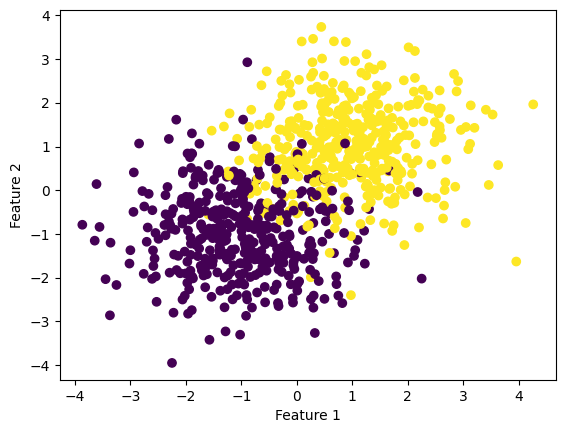

In [2]:
#| code-fold: false

# Create dataset
seed = 12345
features = 3

X, y = make_blobs(n_samples=800, centers=[(-1, -1), (1, 1)], n_features=features-1, random_state=seed)

fig = plt.scatter(X[:,0], X[:,1], c = y)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")

From here we can examine the performance of our simplest implementation of logistic regression. We will use the `LogisticRegression` class defined in our source files.

Note: our `LogisticRegression` class is seeded. This allows us to directly compare the results of our various implementations.

We will use the `fit` method to fit our model to the data using normal gradient descent. We can use the `predict` method to make predictions on future data. And we can use the `score` method to evaluate the accuracy of our model. 

In [48]:
#| code-fold: false

from LogisticRegression import LogisticRegression

# Create model
LR = LogisticRegression(epsilon=1e-3, seed=seed)

# Fit model
LR.fit(X, y, alpha=0.1, epochs=1000)

Fit model with gradient descent in 390/1000(max) epochs.


We can access the loss and accuracy history of our model using the `loss_history` and `score_history` attributes. We can also access the weights of our model using the `w` attribute.

In [38]:
#| code-fold: false

print(f"Final weights are: {LR.w}")

Final weights are: [1.70105767 1.77488985 0.0742251 ]


In [39]:
#| code-fold: false

print(f"Final score is: {LR.score_history[-1]:.3f}")
print(f"Final loss is: {LR.loss_history[-1]:.3f}")


Final score is: 0.925
Final loss is: 0.194


It would be nice to visualize the decisions our model is making. Doing this will show us where errors are being made. We will call the `LR.predict(X)` method to get the predicted class for each sample in our dataset. We will then plot the correctness of each prediction on a scatter plot.

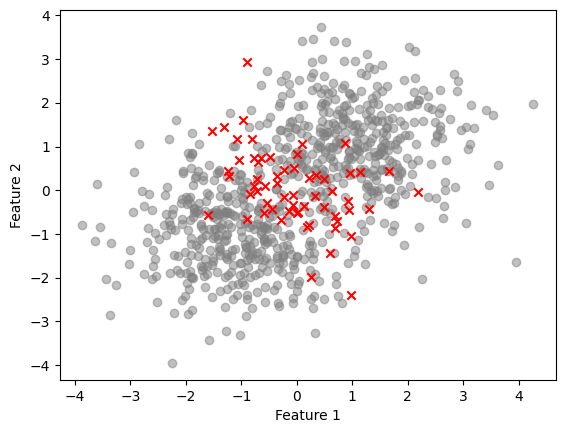

In [59]:
y_preds = LR.predict(X)

correctness = 1*np.equal(y_preds, y)

correct_points = X[correctness == 1]
incorrect_points = X[correctness == 0]

# fig = plt.scatter(X[:,0], X[:,1], c = correctness)
fig = plt.scatter(correct_points[:,0], correct_points[:,1], c = 'grey', alpha=0.5)
fig = plt.scatter(incorrect_points[:,0], incorrect_points[:,1], c = 'red', marker="x")
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")

Here, red points indicate the incorrect predictions, and the grey points indicate the correct predictions. We can see that our model is making some mistakes, but it is still able to make correct predictions. We can also see that our model is not able to separate the two classes perfectly. This is because our model is linear, and the data is not linearly separable. Notice how the errors are concentrated along a line through the middle of the plot.

The decision boundary of our model is the linear boundary that separates the two classes. This visualization of errors indirectly reveals the location of this boundary.

Using the excellent `mlxtend` library, we can precisely plot the decision boundary of our model.

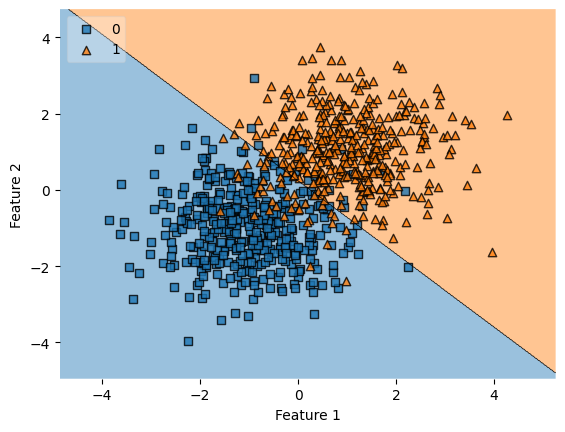

In [41]:
from mlxtend.plotting import plot_decision_regions

fig = plot_decision_regions(X, y, clf=LR, legend=2)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")




Now that we have a basic understanding of how our model works, let's see how it works with its stochastic variants. We will start with stochastic gradient descent without momentum.

Like before, we instantiate our model with the `LogisticRegression` class. We will use the `fit_stochastic` method to fit our model to the data using stochastic gradient descent. Then we can use the familiar `predict`, `score`, `loss_history`, `score_history`, and `w` attributes to examine the model.

In [54]:
#| code-fold: false

LRS = LogisticRegression(epsilon=1e-3, seed=seed)

# Fit model with stochastic gradient descent
LRS.fit_stochastic(X, y, alpha=0.1, batch_size=50, epochs=1000, momentum=False)

Fit model with stochastic gradient descent in 48/1000(max) epochs.


Note how the stochastic variant converged to a solution in ~50 epochs, while the normal variant took ~400  (8x speedup!). This is because the stochastic variant is able to make updates to the model $\frac{n}{b}$ times per epoch where $n$ is the number of points and $b$ is the batch size. This allows it to converge to a solution faster than the normal variant which only makes updates once per epoch.

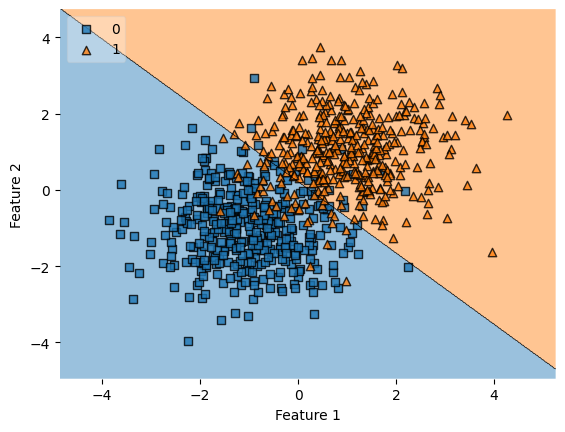

In [55]:
#| echo: false
#| output: false

from mlxtend.plotting import plot_decision_regions

fig = plot_decision_regions(X, y, clf=LRS, legend=2)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")



(0.0, 1.0)

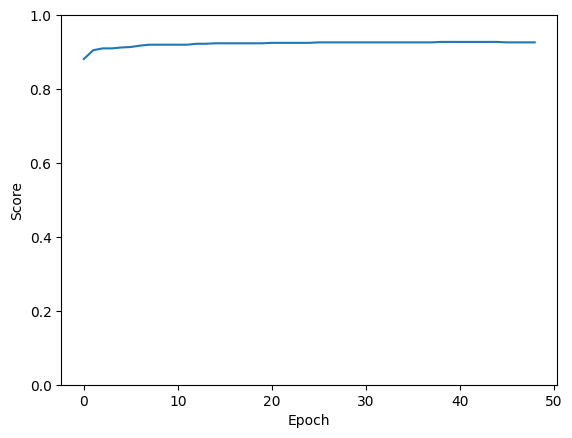

In [56]:
#| echo: false
#| output: false

fig = plt.plot(LRS.score_history)
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Score")

ax = plt.gca()
ax.set_ylim([0,1])

Plotting the loss history of our model shows us how quickly the stochastic variant converges to a solution.

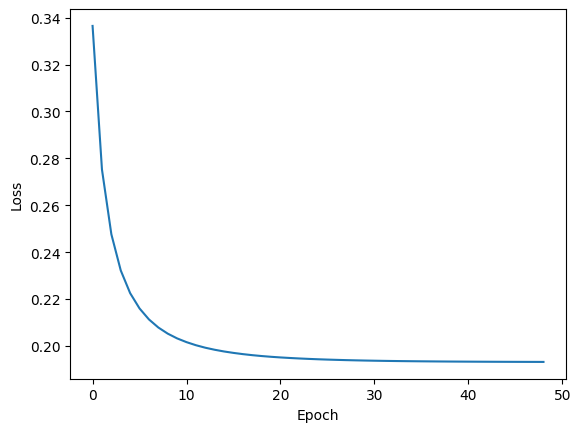

In [57]:
fig = plt.plot(LRS.loss_history)
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")

The introduction of momentum adds a subtle improvement to our stochastic gradient descent. To show this, we will use the `fit_stochastic` method with the `momentum` parameter set to `True`.

In [63]:
LRSM = LogisticRegression(epsilon=1e-3)

# Fit model with stochastic gradient descent
LRSM.fit_stochastic(X, y, alpha=0.1, batch_size=50, epochs=1000, momentum=True)

Fit model with stochastic gradient descent in 183/1000(max) epochs.


We can see that the stochastic variant with momentum converges to a solution in ~200 epochs, which is unexpected since we expect the stochastic gradient descent with momentum to converge faster than the stochastic variant without momentum.


Plotting the loss history of our model shows us that the stochastic variant with momentum gets close to converging to a solution very quickly but does not quite reach the epsilon threshold we set for convergence.


If we overlay the loss history of the stochastic variant with momentum and the stochastic variant without momentum, we can see that the stochastic variant with momentum reduces its loss more quickly than the stochastic variant without momentum.

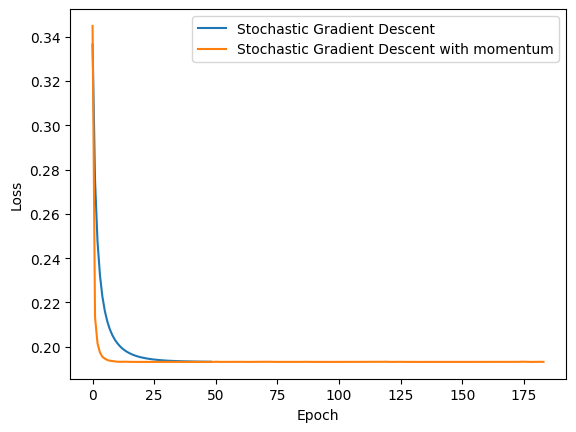

In [70]:
lrs_loss_history = LRS.loss_history
lrsm_loss_history = LRSM.loss_history

fig = plt.plot(lrs_loss_history, label="Stochastic Gradient Descent")
fig = plt.plot(lrsm_loss_history, label="Stochastic Gradient Descent with momentum")
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")

ax = plt.gca()
ax.legend()

None # To suppress Matplotlib output

So our expectations are actually correct. The stochastic variant with momentum does get close to the solution at a faster rate, however, it does not quite reach convergence as quickly as the stochastic variant without momentum.

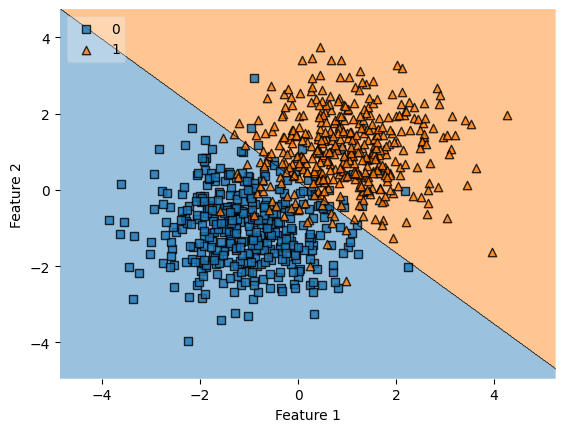

In [68]:
#| output: false
#| echo: false

from mlxtend.plotting import plot_decision_regions

fig = plot_decision_regions(X, y, clf=LRSM, legend=2)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")


In [14]:
#| output: false
#| echo: false

print(f"Score for batch gradient descent with momentum: {LRSM.score(X, y)}")
print(f"Loss for batch gradient descent with momentum: {LRSM.loss_history[-1]}")

Score for batch gradient descent: 0.9225
Loss for batch gradient descent: 0.1931351917919443


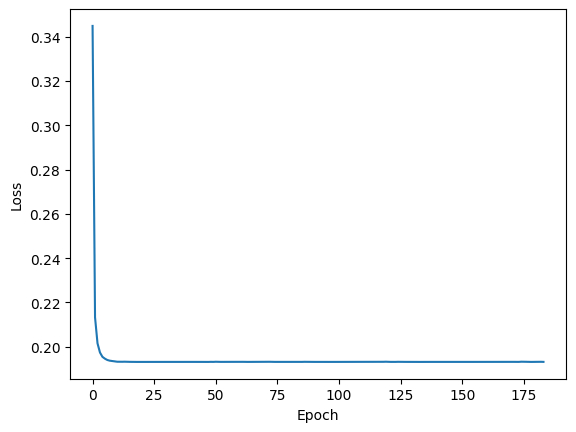

In [64]:
#| echo: false
#| output: false

# Plot loss history

fig = plt.plot(LRSM.loss_history)
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")


(0.0, 1.0)

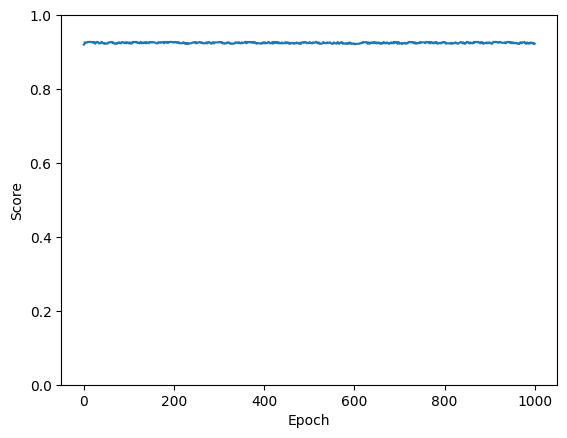

In [16]:
#| output: false
#| echo: false


# Plot score history

fig = plt.plot(LRSM.score_history)
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Score")

ax = plt.gca()

ax.set_ylim([0,1])



Now, let's directly compare the performance of all three types of gradient descent. The following code will fit each of our models to the data and plot the loss history of each model.

Fit model with stochastic gradient descent in 1000/1000(max) epochs.
Fit model with stochastic gradient descent in 1000/1000(max) epochs.
Fit model with gradient descent in 1000/1000(max) epochs.


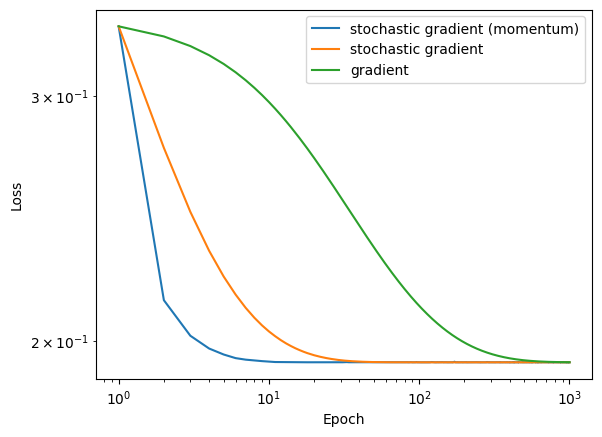

In [76]:
#| code-fold: false

y_scale = [0, 1]

seed = 12345

LR = LogisticRegression(seed=seed)
LR.fit_stochastic(X, y, 
                  epochs = 1000, 
                  momentum = True, 
                  batch_size = 50, 
                  alpha = .1) 

num_steps = len(LR.loss_history)
plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "stochastic gradient (momentum)")

LR = LogisticRegression(seed=seed)
LR.fit_stochastic(X, y, 
                  epochs = 1000, 
                  momentum = False, 
                  batch_size = 50, 
                  alpha = .1)

num_steps = len(LR.loss_history)
plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "stochastic gradient")

LR = LogisticRegression(seed=seed)
LR.fit(X, y, alpha = .1, epochs = 1000)

num_steps = len(LR.loss_history)
plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "gradient")

plt.loglog()

legend = plt.legend() 

plt.xlabel("Epoch")
plt.ylabel("Loss")

ax= plt.gca()


plt.show()

None # To suppress Matplotlib output

This example exemplifies our earlier points about the training times of each type of algorithm. We observe the stochastic variants "converge" onto a solution much faster than the normal variant. And the stochastic variant with momentum converges to a solution faster than the stochastic variant without momentum.

## Examples:




### Example 1: Large alpha leading to divergence


Consider the following example where we set the learning rate to a large value. As earlier claimed, this can lead to divergence of the model.

We will test this claim on the `make_moons` dataset from `sklearn.datasets`. This dataset is not linearly separable.

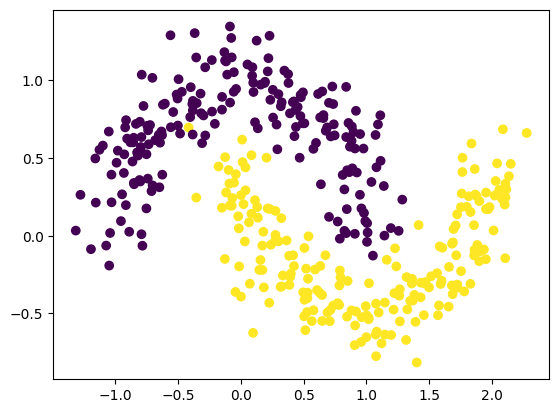

In [80]:
# Example: alpha too large
from sklearn.datasets import make_moons

X_dnc, y_dnc = make_moons(n_samples=400, noise=0.15, random_state=seed)

fig = plt.scatter(X_dnc[:,0], X_dnc[:,1], c = y_dnc)

None # To suppress Matplotlib output

We will fit our model using normal gradient descent. We will set the learning rate to the obscenely large value of 29. Observe how the loss history of our model fails to converge to a solution over the course of 2000 epochs.

Fit model with gradient descent in 2000/2000(max) epochs.


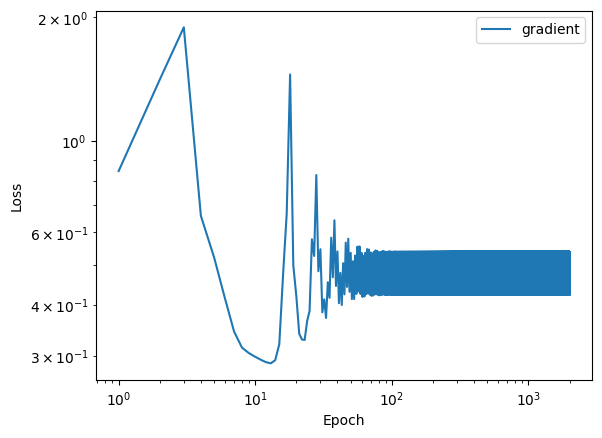

In [89]:
LR = LogisticRegression()
LR.fit(X_dnc, y_dnc, alpha = 29, epochs = 2000)

num_steps = len(LR.loss_history)

plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "gradient")

plt.loglog()

legend = plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

ax= plt.gca()

plt.show()

None # To suppress Matplotlib output

So clearly the model is not going to converge. But maybe this is just a fluke. Let's try again with a smaller learning rate. We will set the learning rate to 0.1. This is a reasonable value for a learning rate. Observe how the loss history of our model converges to a solution over the course of 2000 epochs.

Fit model with gradient descent in 2000/2000(max) epochs.


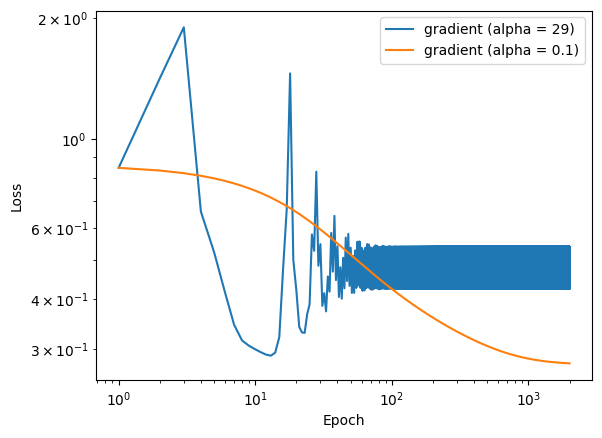

In [90]:
LR2 = LogisticRegression()
LR2.fit(X_dnc, y_dnc, alpha = 0.1, epochs = 2000)

num_steps = len(LR2.loss_history)

plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "gradient (alpha = 29)")
plt.plot(np.arange(num_steps) + 1, LR2.loss_history, label = "gradient (alpha = 0.1)")

plt.loglog()

legend = plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

ax= plt.gca()

plt.show()

None # To suppress Matplotlib output

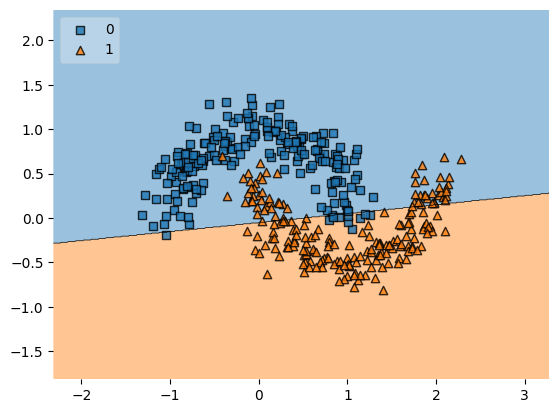

In [20]:
#| output: false
#| echo: false

# Plot decision boundary
from mlxtend.plotting import plot_decision_regions

fig = plot_decision_regions(X_dnc, y_dnc, clf=LR, legend=2)

### Example 2: Batch size & convergence speed

With stochastic gradient descent, we can control the convergence speed of our model by adjusting the batch size. Again, we will test this claim on the `make_moons` dataset from `sklearn.datasets`. This dataset is not linearly separable.


Using two models of stochastic gradient descent with momentum with differing batch sizes (20 and 100), we will show that the batch size controls the convergence speed of the model.

Fit model with stochastic gradient descent in 1000/1000(max) epochs.
Fit model with stochastic gradient descent in 1000/1000(max) epochs.


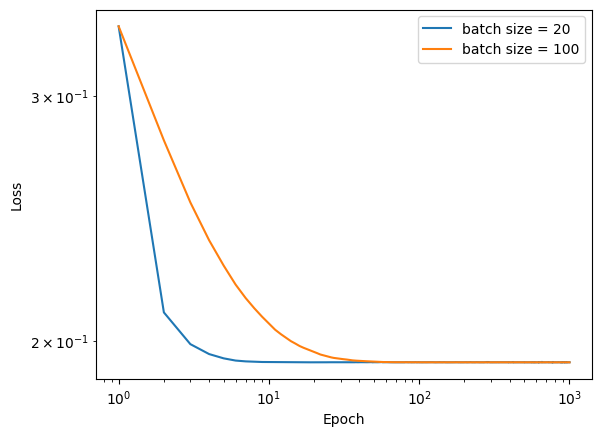

In [21]:
# Batch size influencing convergence time

seed = 12345

LR20 = LogisticRegression(seed=seed)
LR20.fit_stochastic(X, y, alpha = 0.05, epochs = 1000, momentum = True, batch_size = 20)

LR100 = LogisticRegression(seed=seed)
LR100.fit_stochastic(X, y, alpha = 0.05, epochs = 1000, momentum = True, batch_size = 100)


# Plot loss history
num_steps = len(LR20.loss_history)
plt.plot(np.arange(num_steps) + 1, LR20.loss_history, label = "batch size = 20")
plt.plot(np.arange(num_steps) + 1, LR100.loss_history, label = "batch size = 100")

legend = plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.loglog()

ax= plt.gca()

plt.show()

Observe how the model with a smaller batch size (20) converges to a solution much faster than the model with a larger batch size (100). This is because the model with a smaller batch size makes more updates per epoch than the model with a larger batch size.

This does not mean small sizes are always better. For example, if we use a batch size of 2, the model can bounce around our minimizer and not converge to a solution. This is because the model with a batch size of 2 makes worse average approximations to the gradient. And such a small sample size would be very noisy.

Observe that the model with a batch size of 2 leads to a noisy loss history.

Fit model with stochastic gradient descent in 1000/1000(max) epochs.
Fit model with stochastic gradient descent in 1000/1000(max) epochs.


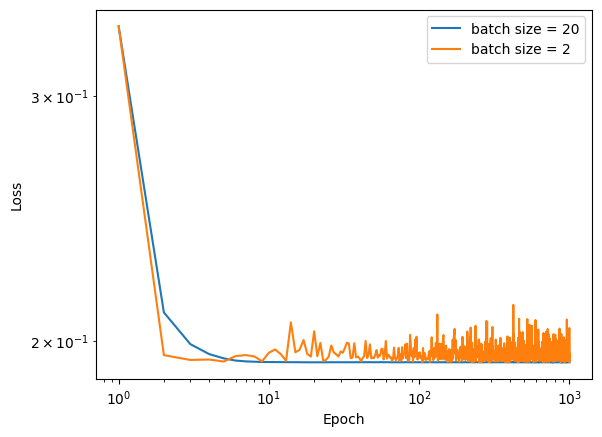

In [93]:
# Batch size influencing convergence time

seed = 12345

LR20 = LogisticRegression(seed=seed)
LR20.fit_stochastic(X, y, alpha = 0.05, epochs = 1000, momentum = True, batch_size = 20)

LR1 = LogisticRegression(seed=seed)
LR1.fit_stochastic(X, y, alpha = 0.05, epochs = 1000, momentum = True, batch_size = 2)


# Plot loss history
num_steps = len(LR20.loss_history)
plt.plot(np.arange(num_steps) + 1, LR20.loss_history, label = "batch size = 20")
plt.plot(np.arange(num_steps) + 1, LR1.loss_history, label = "batch size = 2")

legend = plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.loglog()

ax= plt.gca()

plt.show()

### Example 3: SGD with momentum speeding up convergence on high dimensional data

We will show that stochastic gradient descent with momentum can speed up convergence on high dimensional data. We will use the `make_blobs` dataset from `sklearn.datasets` to generate a dataset with 10 features and 2 classes. We use a large sample size of 40,000 observations.

Fit model with gradient descent in 1000/1000(max) epochs.
Fit model with stochastic gradient descent in 1000/1000(max) epochs.
Fit model with stochastic gradient descent in 1000/1000(max) epochs.


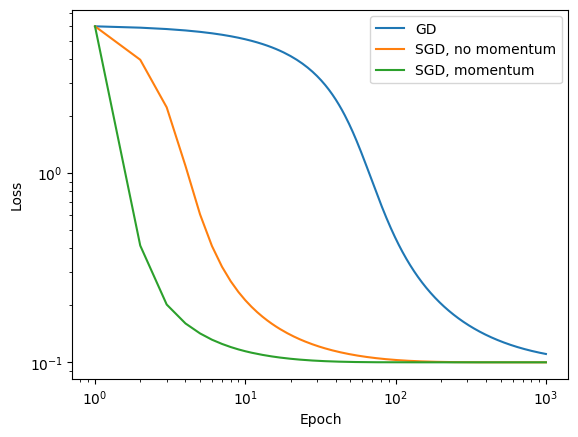

In [22]:
# Example: momentum leading to faster convergence
seed = 12345
epochs = 1000
alpha = 0.01

np.random.seed(seed)
n_features = 10
centers = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
X_m, y_m = make_blobs(n_samples=40000, n_features=n_features, centers=centers, random_state=seed, cluster_std=1.8)

LR = LogisticRegression(seed)
LR.fit(X_m, y_m, alpha = alpha, epochs = epochs)

LRS = LogisticRegression(seed)
LRS.fit_stochastic(X_m, y_m, alpha = alpha, epochs = epochs, momentum = False, batch_size = 2000)

LRM = LogisticRegression(seed)
LRM.fit_stochastic(X_m, y_m, alpha = alpha, epochs = epochs, momentum = True, batch_size = 2000)


num_steps = len(LR.loss_history)
plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "GD")
plt.plot(np.arange(num_steps) + 1, LRS.loss_history, label = "SGD, no momentum")
plt.plot(np.arange(num_steps) + 1, LRM.loss_history, label = "SGD, momentum")

legend = plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.loglog()

ax= plt.gca()

plt.show()

Here we observe the significant speedup offered by stochastic gradient descent with momentum. The stochastic variant with momentum converges to a solution in ~100 epochs, while the stochastic variant without momentum converges to a solution in ~1000 epochs. And the normal variant converges to a solution in >10,000 epochs.

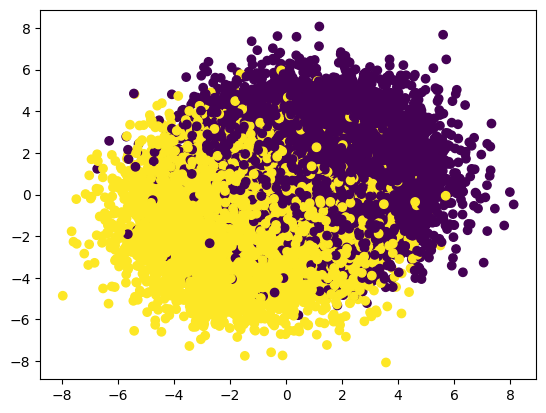

In [23]:
#| output: false
#| echo: false

# plot data

fig = plt.scatter(X_m[:,0], X_m[:,1], c = y_m)

# plot decision boundary

from mlxtend.plotting import plot_decision_regions

# fig = plot_decision_regions(X_m, y_m, clf=LRM, legend=2)

In [24]:
#| output: false
#| echo: false

print(f"LRM score: {LRM.score(X_m, y_m)}")

LRM score: 0.960325


### Example 4: Large epsilon leading to early exit

Consider the following example where we set the epsilon threshold to a large value (0.01).

In [94]:
# Example: large epsilon leading to early exit

seed = 12345
epochs = 1000
alpha = 0.05
epilson = 0.01

kwargs = {"seed": seed, "epsilon": epilson}
LR = LogisticRegression(**kwargs)

LR.fit(X, y, alpha = alpha, epochs = epochs)

# LR.score(X, y)


Fit model with gradient descent in 13/1000(max) epochs.


Observe how the model exiting in 13 epochs. If $\epsilon$ is too large, the model will exit before it has converged to the actual minimizer. This is bad. In general, we want to set $\epsilon$ to a small value.